## Holographic Reconstruction on GPU (TensorFlow)

In [1]:
import numpy as np
import os
from skimage.restoration import unwrap_phase
from fringe.utils.io import import_image, import_image_seq, export_image
from fringe.utils.modifiers import ImageToArray, PreprocessHologram, ConvertToTensor
from fringe.process.gpu import AngularSpectrumSolver as AsSolver, MultiHeightPhaseRecovery as MHPR
import tensorflow as tf
import matplotlib
from matplotlib import pyplot as plt

#### Choose Device
Choose the processing device from cpu, gpu, or tpu

In [2]:
# choose device here
device = 'gpu'

if device == "gpu":
  if len(tf.config.experimental.list_physical_devices('GPU')) > 0:
    print('GPU is up and running')
    device = "/gpu:0"
  else:
    print('GPU is not available. The program will run on CPU')
    device = "/cpu:0"
elif device == "tpu":
  if len(tf.config.experimental.list_physical_devices('TPU')) > 0:
    print('TPU is up and running')
    device = "/tpu:0"
  else:
    print('TPU is not available. The program will run on CPU')
    device = "/cpu:0"
else:
  device = "/cpu:0"

dtype_f = tf.float32
dtype_c = tf.complex64

GPU is not available. The program will run on CPU


### Back Propagation
Forward reconstruction of inline holograms using angular spectrum method.
#### Import Images
- Specify paths to the background (if exists) and hologram images.
- Images are needed to be standardized using ProcessHologram class and converted to tensors ConvertToTenso class

Image imported from: D:/GoogleDrive_/Colab/Dataset/Custom/background1.tif
Image imported from: D:/GoogleDrive_/Colab/Dataset/Custom/cheek/2.tif
tf.Tensor(
[[0.95144314+0.j 0.9506724 +0.j 0.96627367+0.j ... 1.0882852 +0.j
  1.0381945 +0.j 1.0710317 +0.j]
 [0.9306847 +0.j 0.9282853 +0.j 0.9338297 +0.j ... 1.0450132 +0.j
  0.9390327 +0.j 0.9897268 +0.j]
 [0.97109175+0.j 0.9854329 +0.j 0.99051106+0.j ... 1.0671922 +0.j
  0.98994833+0.j 0.94394714+0.j]
 ...
 [1.        +0.j 1.        +0.j 1.0638723 +0.j ... 1.2766048 +0.j
  1.4165211 +0.j 1.1874449 +0.j]
 [1.0202123 +0.j 0.9848408 +0.j 1.0440452 +0.j ... 1.316659  +0.j
  1.169962  +0.j 1.065424  +0.j]
 [1.1202958 +0.j 1.0244696 +0.j 1.0728353 +0.j ... 1.0601478 +0.j
  0.94033337+0.j 1.2505894 +0.j]], shape=(512, 512), dtype=complex64)


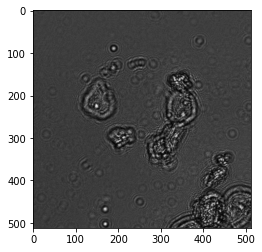

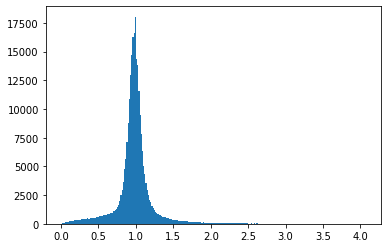

In [3]:
bg_path = "PATH_TO_BACKGROUND_IMAGE.tif"
h_path = "images/sequence/0_300.tif"
p1 = ImageToArray(bit_depth=16, channel='gray', crop_window=[850, 1000, 512, 512], dtype='float32')
#bg = import_image(bg_path, preprocessor=p1)
bg = np.ones((512, 512))  # if no background
p2 = PreprocessHologram(background=bg)
p3 = ConvertToTensor(dtype=dtype_c)
h = import_image(h_path, preprocessor=[p1, p2, p3])

z = -300

#### Solve
- Initialize angular spectrum solver.
- Call solver.reconstruct() and pass the complex-valued hologram and its z distance as parameters.

In [ ]:
solver = AsSolver(shape=h.shape, dx=1.12, dy=1.12, wavelength=532e-3)

amp = np.abs(solver.solve(h, z))
phase = unwrap_phase(np.angle(solver.solve(h, z)))

plt.imshow(amp, cmap='gray')
plt.show()
plt.imshow(phase, cmap='viridis')
plt.show()

### Multi-Height-Phase-Recovery (MHPR)
Iterative phase retrieval procedure for inline holograms using a sequence of axially displaced hologram images.
#### Import images
- Specify paths to background image (if exists) and hologram sequence and assign their heights in the <b><i>z_values</i></b> array.

In [ ]:
bg_path = "PATH_TO_BACKGROUND_IMAGE.tif"

img_seq_paths = [
	"images/sequence/0_300.tif",
	"images/sequence/1_350.tif",
	"images/sequence/2_400.tif",
	"images/sequence/3_450.tif",
	"images/sequence/4_500.tif",
	"images/sequence/5_550.tif",
	"images/sequence/6_600.tif",
	"images/sequence/7_650.tif"
]

p1 = ImageToArray(bit_depth=16, channel='gray', crop_window=None, dtype='float32')
p2 = ConvertToTensor(dtype=dtype_c)
#bg = import_image(bg_path, preprocessor=[p1, p2])
bg = np.ones((512, 512))  # if no background
p3 = PreprocessHologram(background=bg)
h_seq = import_image_seq(img_seq_paths, preprocessor=[p1, p2, p3])

z_values = [-300, -350, -400,-450, -500, -550, -600, -650]
iterations = 100

##### Solve
- Initialize angular spectrum solver.
- Initialize MHPR and pass the solver as parameter.
- Call mhpr.resolve() and pass hologram sequence, z_values and number of iterations to the as input parameters.

In [ ]:
solver = AsSolver(shape=h_seq[0].shape, dx=1.12, dy=1.12, wavelength=532e-3, dtype_f=dtype_f, dtype_c=dtype_c)

with tf.device(device):
    mhpr = MHPR(solver)
    recovered_h = mhpr.solve(h_seq, z_values, iterations)
    amp = np.abs(recovered_h)
    phase = unwrap_phase(np.angle(recovered_h))
    phase += np.pi
    phase /= 2 * np.pi

    plt.imshow(amp, cmap='gray')
    plt.show()
    plt.imshow(phase, cmap='viridis')
    plt.show()

#### Export Results

In [ ]:
cmap = matplotlib.cm.get_cmap('viridis')

export_image(amp, os.path.join('images/exports', 'amplitude.png'), dtype='uint8')
export_image(phase, os.path.join('images/exports', 'phase.png'), dtype='uint8')
export_image(cmap(phase), os.path.join('images/exports', 'phase_colored.png'), dtype='uint8')
